In [4]:
import numpy as np
from numpy import pi, cos, sqrt, zeros
from numpy.random import randn

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import loadmat

from filters import LMS, NLMS

In [23]:
def exp5(a, mu_0, epsilon, total_time, N):
    n = np.arange(total_time)
    
    adaptation_delay = 100
    
    EMSE_LMS = zeros(total_time - adaptation_delay)
    EMSE_NLMS = zeros(total_time - adaptation_delay)
    EMSE_RLS = zeros(total_time - adaptation_delay)
    for i in range(N):
        sigma_u = sqrt(1)
        u = randn(total_time) * sigma_u
        x = signal.lfilter(b=[sqrt(1 - a ** 2)], a=[1, -a], x=u)
        sigma_x = sigma_u

        sigma_v = sqrt(.01)
        v = randn(total_time) * sigma_v

        H = randn(100)
        H = H / np.linalg.norm(H)
        
        y = signal.lfilter(b=H, a=1, x=x)

        d = y + v

        M = len(H)
        lms_filter = LMS(M=M, mu=mu_0 / (M * sigma_x + epsilon))
        nlms_filter = NLMS(M=M, mu_0=mu_0, epsilon=epsilon)

        for j in range(adaptation_delay, total_time):
            lms_filter.buffer(x[j], d[j])
            nlms_filter.buffer(x[j], d[j])

        sigma_o = sigma_v
        EMSE_LMS += (1 / N) * (np.square(lms_filter.e) - sigma_o ** 2)
        EMSE_NLMS += (1 / N) * (np.square(nlms_filter.e) - sigma_o ** 2)
        #EMSE_RLS += (1 / N) * (np.square(rls_filter.e) - sigma_o ** 2)
        
    return n[adaptation_delay:], EMSE_LMS, EMSE_NLMS

## Sinal nao correlacionado

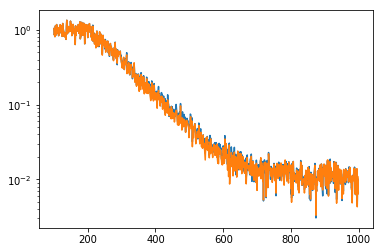

In [24]:
n, EMSE_LMS, EMSE_NLMS = exp5(a=0, mu_0=1, epsilon=0, total_time=1000, N=100)
plt.semilogy(n, EMSE_LMS, n, EMSE_NLMS)
plt.title('Curva de aprendizado dos algoritmos')
plt.legend(['LMS', 'NLMS'])

## Sinal correlacinado

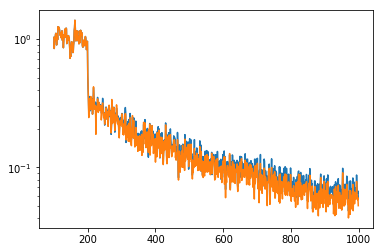

In [25]:
n, EMSE_LMS, EMSE_NLMS = exp5(a=.9, mu_0=.3, epsilon=0, total_time=1000, N=100)
plt.semilogy(n, EMSE_LMS, n, EMSE_NLMS)